In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt

import json
import corner
import retrieval_base.auxiliary_functions as af

In [2]:
def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike.pkl')

    try:
        Cov = af.pickle_load(prefix+'data/bestfit_Cov.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_all_2/test_', n_params=32
    )
posterior_2, bestfit_2, PT_2, Chem_2, int_contr_em_2, int_contr_em_per_order_2, int_opa_cloud_2, m_spec_2, d_spec_2, LogLike_2, Cov_2, bestfit_params_2 = res

res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_log_Kzz_4/test_', n_params=29
    )
posterior_4, bestfit_4, PT_4, Chem_4, int_contr_em_4, int_contr_em_per_order_4, int_opa_cloud_4, m_spec_4, d_spec_4, LogLike_4, Cov_4, bestfit_params_4 = res

del res

  analysing data from ./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_all_2/test_.txt
(4027, 32)
  analysing data from ./retrieval_outputs/DENIS_J0255_chem_eq_log_Kzz_4/test_.txt
(4356, 29)


In [3]:
print(
    bestfit_params_2['params']['log_g'], bestfit_params_4['params']['log_g']
)

5.329244237724955 5.2376051017672145


In [6]:
upper_K_zz = 2.5e10 * (1400/600)**(8/3) * (1000/10**bestfit_params_2['params']['log_g'])
print('{:.1e}'.format(upper_K_zz))

1.1e+09


In [18]:
from petitRADTRANS import nat_cst as nc

def K_zz(pressure, temperature, P_quench, MMW, FeH, log_g, alpha=1, key='P_quench_CO_CH4'):

    T_quench = np.interp(
        np.log10(P_quench), np.log10(pressure), temperature
        )
    MMW_quench = np.interp(
        np.log10(P_quench), np.log10(pressure), MMW
        )
    
    met = 10**FeH
    
    if key == 'P_quench_CO_CH4':
        t_CO_CH4_q1 = 1.5e-6 * P_quench**(-1) * met**(-0.7) * np.exp(42000/T_quench)
        t_CO_CH4_q2 = 40 * P_quench**(-2) * np.exp(25000/T_quench)

        t_chem = (1/t_CO_CH4_q1 + 1/t_CO_CH4_q2)**(-1)
    
    elif key == 'P_quench_NH3':
        t_chem = 1.0e-7 * P_quench**(-1) * np.exp(52000/T_quench)

    # Scale height
    H = (nc.kB*T_quench / (MMW_quench*nc.amu*10**log_g))

    # Mixing length scale
    L = alpha*H

    # Vertical diffusion coefficient
    K_zz = L**2 / t_chem

    return K_zz, t_chem

K_zz_posterior, t_chem_posterior = [], []
for i, sample_i in enumerate(posterior_2):

    log_g = sample_i[9]
    FeH = sample_i[17]

    temperature = PT_2.temperature_posterior[i]
    P_quench = Chem_2.P_quench_posterior['P_quench_CO_CH4'][i]
    MMW = Chem_2.mass_fractions_posterior['MMW'][i]

    K_zz_i, t_chem_i = K_zz(PT_2.pressure, temperature, P_quench, MMW, FeH, log_g)

    K_zz_posterior.append(K_zz_i)
    t_chem_posterior.append(t_chem_i)

K_zz_posterior = np.array(K_zz_posterior)
t_chem_posterior = np.array(t_chem_posterior)

q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])

print('{:.1e} {:.1e} {:.1e}'.format(np.median(K_zz_posterior), *np.quantile(K_zz_posterior, q=q[[2,4]])-np.median(K_zz_posterior)))
print('{:.2e} {:.2e} {:.2e}'.format(np.median(K_zz_posterior), *np.quantile(K_zz_posterior, q=q[[2,4]])-np.median(K_zz_posterior)))
print()
print('{:.1f} {:.1f} {:.1f}'.format(np.median(t_chem_posterior), *np.quantile(t_chem_posterior, q=q[[2,4]])-np.median(t_chem_posterior)))
print('{:.2f} {:.2f} {:.2f}'.format(np.median(t_chem_posterior), *np.quantile(t_chem_posterior, q=q[[2,4]])-np.median(t_chem_posterior)))
print('\n---------------------------------------------------------------\n')

K_zz_posterior, t_chem_posterior = [], []
for i, sample_i in enumerate(posterior_2):

    log_g = sample_i[9]
    FeH = sample_i[17]

    temperature = PT_2.temperature_posterior[i]
    P_quench = Chem_2.P_quench_posterior['P_quench_NH3'][i]
    MMW = Chem_2.mass_fractions_posterior['MMW'][i]

    K_zz_i, t_chem_i = K_zz(
        PT_2.pressure, temperature, P_quench, MMW, FeH, log_g, key='P_quench_NH3'
        )

    K_zz_posterior.append(K_zz_i)
    t_chem_posterior.append(t_chem_i)

K_zz_posterior = np.array(K_zz_posterior)
t_chem_posterior = np.array(t_chem_posterior)

q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])

print('{:.1e} {:.1e} {:.1e}'.format(np.median(K_zz_posterior), *np.quantile(K_zz_posterior, q=q[[2,4]])-np.median(K_zz_posterior)))
print('{:.2e} {:.2e} {:.2e}'.format(np.median(K_zz_posterior), *np.quantile(K_zz_posterior, q=q[[2,4]])-np.median(K_zz_posterior)))
print()
print('{:.1f} {:.1f} {:.1f}'.format(np.median(t_chem_posterior), *np.quantile(t_chem_posterior, q=q[[2,4]])-np.median(t_chem_posterior)))
print('{:.2f} {:.2f} {:.2f}'.format(np.median(t_chem_posterior), *np.quantile(t_chem_posterior, q=q[[2,4]])-np.median(t_chem_posterior)))

P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench_CO_CH4
P_quench

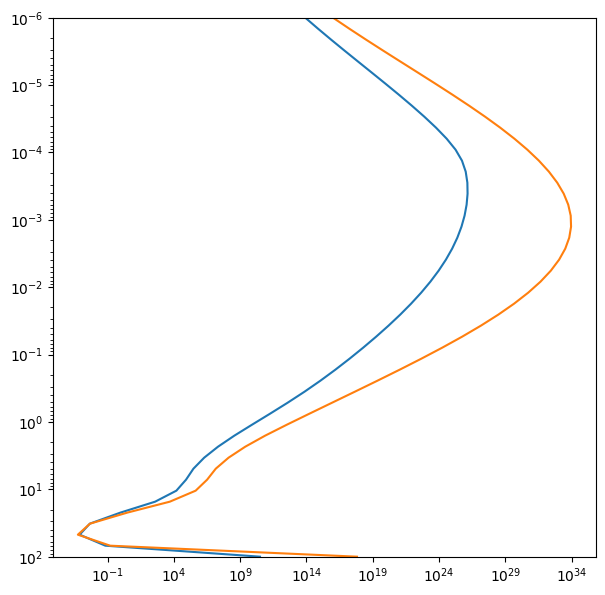

In [22]:
met = 1

t_CO_CH4_q1 = 1.5e-6 * PT_4.pressure**(-1) * met**(-0.7) * np.exp(42000/PT_4.temperature)
t_CO_CH4_q2 = 40 * PT_4.pressure**(-2) * np.exp(25000/PT_4.temperature)

t_CO_CH4 = (1/t_CO_CH4_q1 + 1/t_CO_CH4_q2)**(-1)

t_NH3 = 1.0e-7 * PT_4.pressure**(-1) * np.exp(52000/PT_4.temperature)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(t_CO_CH4, PT_4.pressure)
ax.plot(t_NH3, PT_4.pressure)

ax.set(
    yscale='log', xscale='log', ylim=(1e2,1e-6)
    )
plt.show()

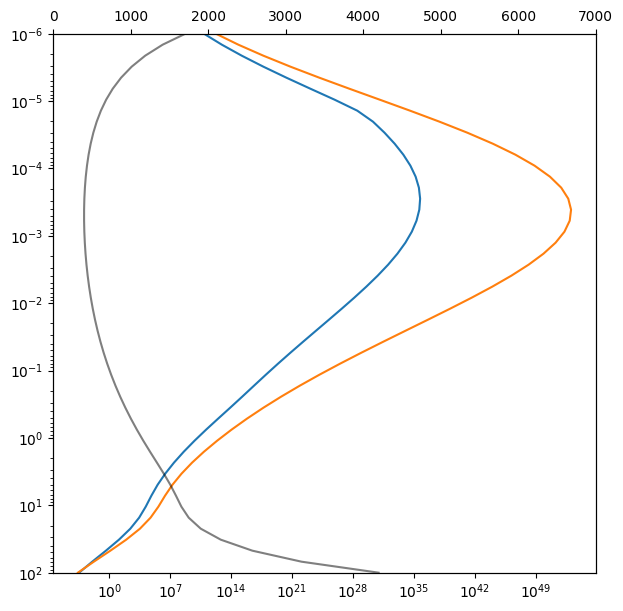

In [34]:
met = 1

t_CO_CH4_q1 = 1.5e-6 * PT_2.pressure**(-1) * met**(-0.7) * np.exp(42000/(PT_2.temperature))
t_CO_CH4_q2 = 40 * PT_2.pressure**(-2) * np.exp(25000/(PT_2.temperature))

t_CO_CH4 = (1/t_CO_CH4_q1 + 1/t_CO_CH4_q2)**(-1)

t_NH3 = 1.0e-7 * PT_2.pressure**(-1) * np.exp(52000/(PT_2.temperature))

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(t_CO_CH4, PT_2.pressure)
ax.plot(t_NH3, PT_2.pressure)

ax_PT = ax.twiny()
ax_PT.plot(PT_2.temperature, PT_2.pressure, c='k', alpha=0.5)
ax_PT.set(xlim=(0,7000))

ax.set(
    yscale='log', xscale='log', ylim=(1e2,1e-6)
    )
plt.show()